In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Clean up and group data by trips
vesel moving from N-H or H-N is considered as a complete trip

In [131]:
df = pd.read_csv("../../queenCsvOut.csv", skiprows=[1])
# plot_df = df[df.LATITUDE>48.9]

### There are some movements that does not belong to either N-H nor H-N trips

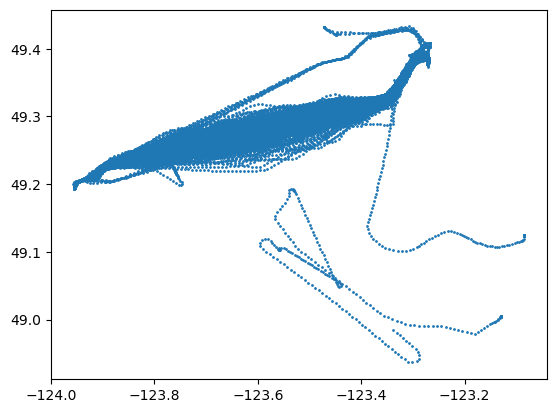

In [165]:
plot_df = df[df.LATITUDE>48.9]
plt.scatter(plot_df.LONGITUDE, plot_df.LATITUDE, s=1)

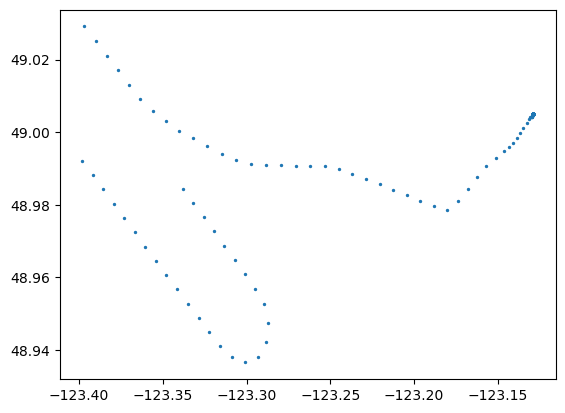

In [166]:
plot_df = df[df.LATITUDE>48.9]
tmp = plot_df[(plot_df["LATITUDE"]<49.1) & (plot_df["LONGITUDE"]> -123.4)]
plt.scatter(tmp.LONGITUDE, tmp.LATITUDE, s=2)

When LONGITUDE is missing, and both thrusts == 0, these data does not contain any information about how the vessel is driving. It is safe to drop them.

In [19]:
# When LONGITUDE is missing, and both thrusts == 0, 
df[pd.isna(df.LONGITUDE) & (df.THRUST_1==0) &(df.THRUST_2==0)].sum()[df[pd.isna(df.LONGITUDE) & (df.THRUST_1==0) &(df.THRUST_2==0)].sum()==0]

LATITUDE              0.0
LONGITUDE             0.0
PAX                   0.0
POWER_1               0.0
POWER_2               0.0
SOG                   0.0
SOG_SPEEDLOG_LONG     0.0
SOG_SPEEDLOG_TRANS    0.0
SPEED_2               0.0
THRUST_1              0.0
THRUST_2              0.0
TORQUE_1              0.0
TORQUE_2              0.0
WIND_ANGLE_TRUE       0.0
WIND_SPEED_TRUE       0.0
dtype: object

In [132]:
# df = df[~(pd.isna(df.LONGITUDE))]
df = df[~(pd.isna(df.LONGITUDE) & (df.THRUST_1==0) &(df.THRUST_2==0))]

### Divide trips
Now, divide the data into trips, each with a unique trip id
The records have trip id 0 when the vessel is parking at bay

In [ ]:
# Horseshoe Bay
# 49.3771, -123.2715
H_lat = 49.3771
H_long = -123.2715

# Nanaimo 
# 49.1936, -123.9554
N_lat = 49.1936
N_long = -123.9554

# Give each trip an ID (from H to N or N to H is counted as a complete trip)
# thresh: threshold for the area of the bay
def number_trip(bay_thresh = 1e-6, speed_thres=1):
    trip = np.zeros(df.shape[0])
    trip_id = 1
    trip[0] = trip_id
    prev_at_bay = True
    flag = True
    for i in range(1, len(df)):
        if (i % 50000)==0:
            print(i)
        H_dist = (df.iloc[i].LONGITUDE - H_long)**2 + (df.iloc[i].LATITUDE - H_lat)**2
        N_dist = (df.iloc[i].LONGITUDE - N_long)**2 + (df.iloc[i].LATITUDE - N_lat)**2
        # decide if the vessel in near the bay
        at_bay = (H_dist < bay_thresh) | (N_dist < bay_thresh)
        if (at_bay):
            # just enter the bay area
            # use flag to check if a new trip is counted
            if (prev_at_bay==False):
                flag = False
            # slows down, means the vessel is likely to be arrived
            # if hasn't generate a new trip id, do so
            if (flag==False) & (df.iloc[i].SOG <= speed_thres):
                trip_id += 1
                flag = True
            # if the vessel speed is very low near the bay area
            # parking at the bay, set trip id to 0
            if (df.iloc[i].SOG <= speed_thres):
                trip[i] = 0
            else:
                trip[i] = trip_id
        else:
            # if leave the bay, but new trip id hasn't been assigned
            # assgin new trip id
            if flag==False:
                trip_id += 1
                flag=True
            trip[i] = trip_id
        prev_at_bay = at_bay
    return trip

df.dropna(axis=0, thresh=35, inplace=True)
df["trip_id"] = number_trip().astype(int)


In [22]:
df.trip_id.min(), df.trip_id.max()

(0, 4083)

In [ ]:
df.groupby(df.trip_id).count().head(15).Dati

trip_id
0     412951
1         13
2        105
3         12
4        109
5        107
6        106
7        109
8        106
9        105
10       107
11       105
12       112
13       113
14       105
15       107
16       107
17       104
18       109
19       105
Name: Dati, dtype: int64

These are trips with extremely off locations, drop these trips

In [23]:
# These are trips with extremely off locations, drop these trips
off_locations = list(df[df.LATITUDE<49.1].trip_id.unique())
df = df[~df.trip_id.isin(off_locations)]

Remove this abnormal trips along with some others with extremely off Longitude and Latitude

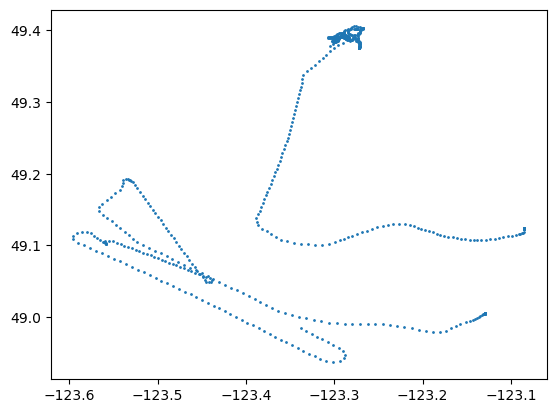

In [ ]:
plt.scatter(df[df.trip_id==2120].LONGITUDE, df[df.trip_id==2120].LATITUDE, s=1)

In [24]:
df.to_csv("../../clean_location.csv", index=False)

In [144]:
df = pd.read_csv("../../clean_location.csv")

### Clean up grouping
The grouping is not very accurate, for example, there are incomplete trips due to missingdata and abnormal trips that has the same starting and end point. This could be caused by two or more trips classfied into one (long_trips), or a short movement misclassfied into a single trip (short_trips). 


#### removing incomplete trips
Typically, a trip from N-H or H-N will take around 100-107 mins (with corresponding lines of data), the median is at 104.
Apperently any trip too long or too short is questionable. \


First, find trips with too much missing data in between(the threshold for too much 10 right now)
Remove the shorter part of these discontinuous trips

In [110]:
df.groupby(df.trip_id).count().Dati.quantile(0.25), df.groupby(df.trip_id).count().Dati.quantile(0.5), df.groupby(df.trip_id).count().Dati.quantile(0.75)

(98.0, 102.0, 105.0)

In [149]:
def get_discontinuous_trip(df, time_thres=10):
    discontinous = {}
    trips = list(df.trip_id.unique())
    trips.remove(0)
    for i in trips:
        tmp_df = df[df.trip_id==i].reset_index()
        fill_in = tmp_df.Time.max()
        tmp_df["time_up"] = tmp_df["Time"].shift(periods=-1, fill_value=fill_in)
        tmp_df["time_diff"] = tmp_df["time_up"] - tmp_df["Time"]
        if tmp_df.time_diff.max() > time_thres:
            discontinous[i] = tmp_df.time_diff.max() 
    return discontinous

trip_dict = get_discontinuous_trip(df, time_thres=10)
trips_to_process = trip_dict.keys()
# trip_dict

For the discontinuous trips, we only preserve the longer (more complete) parts, delete the shorter parts.

In [150]:
# find the time corresponding to the incomplete part of the long trips
def find_drop_times(df, long_trips):
    to_drop = []
    for trip_id in long_trips:
        times = list(df[df.trip_id==trip_id].Time)
        count = 0
        i = 0
        # the jump in time is less than 10 mins
        while((i<len(times)-2) and ((times[i+1]-times[i])< 10)):
            count = count+1
            i = i+1
        # if the more complete trip happens earlier
        if count < len(times)/2:
            drop_time = times[0:count+1]
        elif count+1 == len(times)-1:
            drop_time = [times[-1]]
        else:
            drop_time = times[count+1:-1]
        to_drop = to_drop + drop_time
    return to_drop

# drop the shorter parts in the discontinuous trips
time_to_drop = find_drop_times(df, trip_dict)
df = df[~df.Time.isin(time_to_drop)]
get_discontinuous_trip(df, time_thres=10).keys()

dict_keys([325, 379, 1100, 1677, 3075, 4013])

In [152]:
# After we drop the shorter parts of the discontinuous trips, 
# we can still see some trips that are discontinuous
# This is because our find_drop_times function only slice the trip 
# by the first time it saw a gap,
# run it two times to avoid any trips with two time gaps
# until there is no discontinuous trips
trips_to_process = get_discontinuous_trip(df, time_thres=10).keys()
time_to_drop = find_drop_times(df, trip_dict)
df = df[~df.Time.isin(time_to_drop)]
get_discontinuous_trip(df, time_thres=10)

{3075: 55.0}

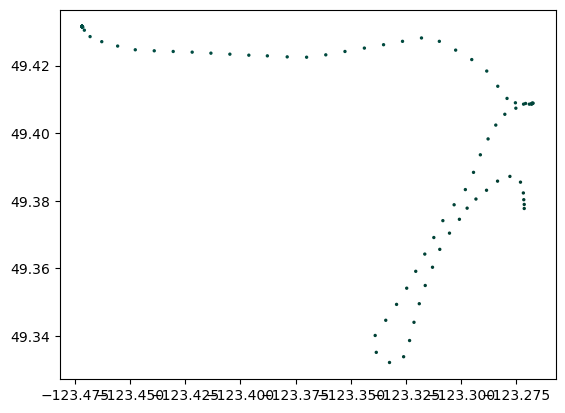

In [155]:
# 3075 is a wierd trip, just remove it from the dataset
plt.scatter(df[df.trip_id==3075].LONGITUDE, df[df.trip_id==3075].LATITUDE, s=2, c=df[df.trip_id==3075].Time, cmap="BrBG")
df = df[df.trip_id!=3075]

After slicing, we will have trips that starts or ends too far away from the bay.\
In other words, they are incomplete trips. Remove these incomplete trips

In [163]:
def incomplete_trips(df, thresh=1e-3):
    incomplete_trips = []
    trips = list(df.trip_id.unique())
    trips.remove(0)
    for trip_id in trips:
        tmp_df = df[df.trip_id==trip_id].reset_index()
        start_H_dist = (tmp_df.iloc[0].LONGITUDE - H_long)**2 + (tmp_df.iloc[0].LATITUDE - H_lat)**2
        start_N_dist = (tmp_df.iloc[0].LONGITUDE - N_long)**2 + (tmp_df.iloc[0].LATITUDE - N_lat)**2
        start_bay_dist = min(start_H_dist, start_N_dist)
        end_H_dist = (tmp_df.iloc[-1].LONGITUDE - H_long)**2 + (tmp_df.iloc[-1].LATITUDE - H_lat)**2
        end_N_dist = (tmp_df.iloc[-1].LONGITUDE - N_long)**2 + (tmp_df.iloc[-1].LATITUDE - N_lat)**2
        end_bay_dist = min(end_H_dist, end_N_dist)
        travel_dist = (tmp_df.iloc[0].LONGITUDE - tmp_df.iloc[-1].LONGITUDE)**2 + \
            (tmp_df.iloc[0].LATITUDE - tmp_df.iloc[-1].LATITUDE)**2
        if (start_bay_dist>thresh) | (end_bay_dist>thresh) | (travel_dist<.15):
            incomplete_trips.append(trip_id)
    df = df[~df.trip_id.isin(incomplete_trips)]
    print(incomplete_trips)
    return df
df = incomplete_trips(df, 1e-3)
df.groupby(df.trip_id).count().Dati[df.groupby(df.trip_id).count().Dati<60]

[1, 3, 213, 233, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 307, 309, 311, 313, 315, 317, 319, 321, 323, 325, 327, 329, 331, 333, 335, 337, 339, 341, 343, 345, 347, 349, 351, 353, 355, 357, 359, 361, 363, 365, 367, 369, 371, 373, 375, 377, 379, 381, 383, 385, 535, 629, 632, 666, 667, 670, 672, 674, 676, 678, 680, 682, 684, 686, 688, 690, 692, 694, 696, 698, 700, 702, 704, 706, 708, 710, 712, 714, 716, 718, 720, 722, 724, 726, 728, 730, 732, 734, 736, 738, 740, 742, 744, 746, 748, 750, 752, 754, 756, 758, 760, 762, 764, 766, 768, 770, 772, 774, 776, 778, 780, 782, 784, 786, 788, 790, 792, 794, 796, 798, 800, 802, 804, 806, 808, 810, 812, 814, 816, 818, 820, 822, 824, 826, 828, 830, 832, 834, 836, 838, 840, 842, 844, 846, 848, 850, 852, 854, 856, 858, 860, 862, 864, 866, 868, 870, 872, 874, 876, 878, 880, 938, 944, 988, 1003, 1004, 1009, 1042, 1046, 1047, 1049, 1

trip_id
3111    46
3481    50
Name: Dati, dtype: int64

In [169]:
df.groupby(df.trip_id).count().Dati[df.groupby(df.trip_id).count().Dati<90]

trip_id
3111    46
3481    50
Name: Dati, dtype: int64

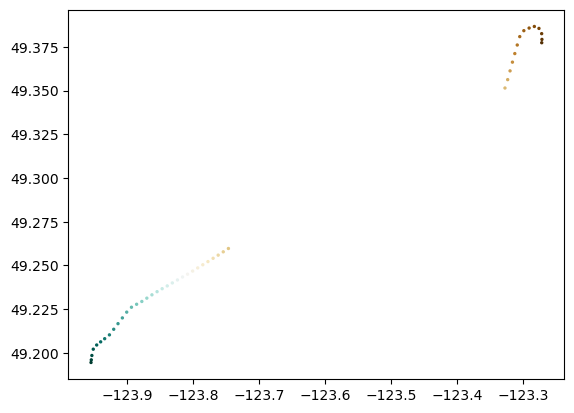

In [170]:
plt.scatter(df[df.trip_id==3111].LONGITUDE, df[df.trip_id==3111].LATITUDE, s=2, c=df[df.trip_id==3111].Time, cmap="BrBG")

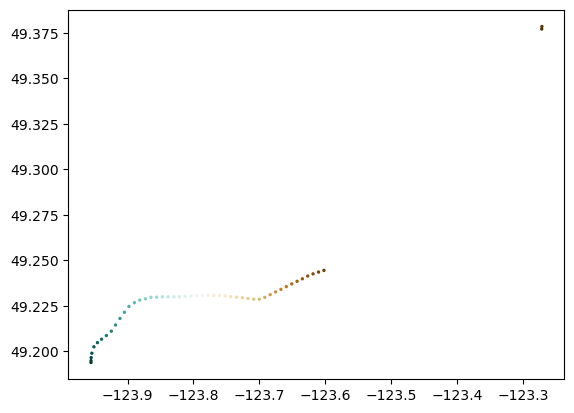

In [159]:
plt.scatter(df[df.trip_id==3481].LONGITUDE, df[df.trip_id==3481].LATITUDE, s=2, c=df[df.trip_id==3481].Time, cmap="BrBG")

trip 3111 and 3481 are another two special cases, they do not have any jump in time, \
in other words, no missing data in between, but they have a location jump\
remove them from the data set

In [171]:
df = df[~df.trip_id.isin([3111,3481])]

Now, look at the trips with too much lines of data 

In [172]:
df.groupby(df.trip_id).count().Dati[df.groupby(df.trip_id).count().Dati>150]

trip_id
0       424861
3733       162
Name: Dati, dtype: int64

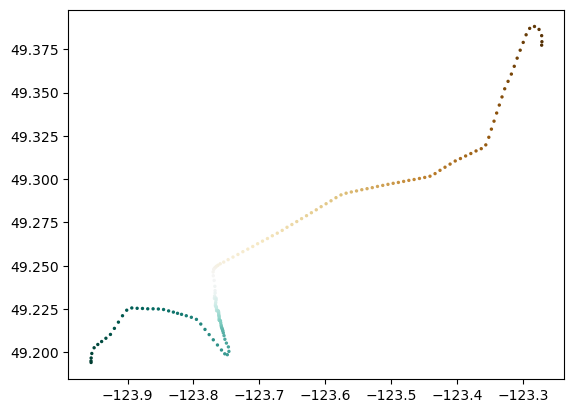

In [173]:
plt.scatter(df[df.trip_id==3733].LONGITUDE, df[df.trip_id==3733].LATITUDE, s=2, c=df[df.trip_id==3733].Time, cmap="BrBG")

3733 is a special case where a detour happened

In [177]:
df.groupby(df.trip_id).count().Dati.min(), df[df.trip_id!=0].groupby(df.trip_id).count().Dati.max()

(94, 162)

Another type of abnormal trips are those that has the same starting and end point. \
This could be caused by two or more trips classfied into one (long_trips), or a short movement misclassfied into a single trip (short_trips). \
We nolonger have these type of trips after previous steps to clean up the data.

In [179]:
def find_round_trip(df):
    short_trip = []
    long_trip = []
    trips = list(df.trip_id.unique())
    trips.remove(0)
    for i in trips:
        tmp_df = df[df.trip_id == i].reset_index()
        start_long, start_lat = tmp_df.iloc[0].LONGITUDE,tmp_df.iloc[0].LATITUDE
        end_long, end_lat = tmp_df.iloc[-1].LONGITUDE,tmp_df.iloc[-1].LATITUDE
        if (abs(start_long - end_long) < 0.005) and (abs(start_lat- end_lat) < 0.005):
            min_long, min_lat = tmp_df.LONGITUDE.min(), tmp_df.LATITUDE.min()
            max_long, max_lat = tmp_df.LONGITUDE.max(), tmp_df.LATITUDE.max()
            if ((max_long-min_long)>0.1) | ((max_lat-min_lat)>0.1):
                long_trip.append(i)
            else:
                short_trip.append(i)
    return short_trip, long_trip
find_round_trip(df)

([], [])

In [183]:
df.trip_id = df.trip_id.astype(int)
df.to_csv("../../df_cleaned_location.csv", index=False)

In [185]:
df.groupby("trip_id").count().Dati.quantile(.01), df.groupby("trip_id").count().Dati.median(), df.groupby("trip_id").count().Dati.quantile(.99)

(98.0, 103.0, 112.0)

In [186]:
df.groupby(df.trip_id).count().Dati.min(), df[df.trip_id!=0].groupby(df.trip_id).count().Dati.max()

(94, 162)

In [4]:
df = pd.read_csv("../../df_cleaned_location.csv")

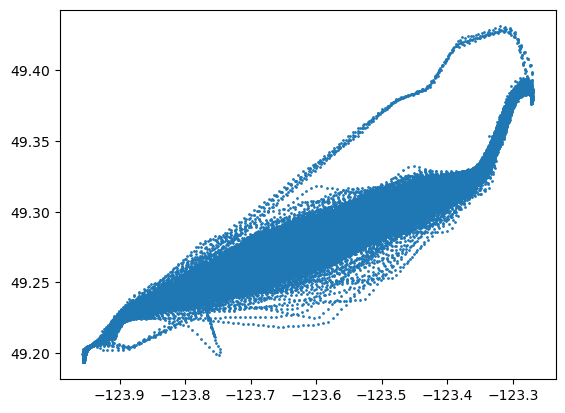

In [187]:
# df = pd.read_csv("../../df_cleaned_location.csv")
plt.scatter(df.LONGITUDE, df.LATITUDE, s=1)

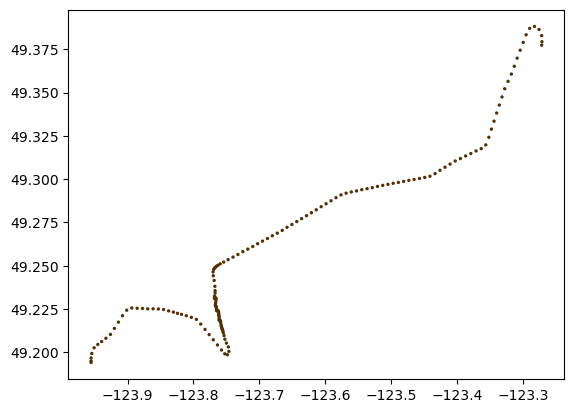

In [8]:
plt.scatter(df[df.trip_id==3733].LONGITUDE, df[df.trip_id==3733].LATITUDE, s=2, c=(df[df.trip_id==3733].PITCH_1)/600, cmap="BrBG")

In [ ]:
df[df.trip_id==3733]